# Modeling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
# from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cynthiaowens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cynthiaowens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Problem Statement: I will build a machine learning model that will
#### * be able to classify extremist from non-extremist Reddit post content over a large dataset (35,000 or more observations)
#### * have an accuracy score of more than 10% over the Zero Rate baseline classifier, the majority group
#### * be able to filter extremist content from similar yet non-extremist content (e.g. other political content that does not meet the definition of 'extremist')

## Import the subset of subreddits, 20_000 split evenly across extremist and non-extremist subreddits, 40_000 total:

In [2]:
data = pd.read_csv('data/subs_to_model.csv')

In [3]:
data.head()

,body,subreddit,word_count,tokenized,clean_content,extreme,adjectives,adj_string
0,- Official slogan of Pepsi,politics,5,official slogan pepsi,offici slogan pepsi,0,['official'],official
1,"""took"" should be ""freed""",ChapoTrapHouse,4,took freed,took freed,1,[],NaN
2,Will tribes be completely free speech?,TheRedPill,6,tribes completely free speech,tribe complet free speech,1,['free'],free
3,Not an accident. They have crowned their queen...,The_Donald,25,accident crowned queen already warren others g...,accid crown queen alreadi warren other get pla...,1,[],NaN
4,Fucking love this man,The_Donald,4,fucking love man,fuck love man,1,['fucking'],fucking


## Check for NANs that have populated the data during the csv export/import process:

In [4]:
data.isna().sum()

body                 0
subreddit            0
word_count           0
tokenized            0
clean_content        0
extreme              0
adjectives           0
adj_string       14507
dtype: int64

## These have been read in as NANs from being empty strings after processing in the previous notebook.

## They are necessary for modeling so we can't drop them.

## Replace any NANs with an empty string:

In [5]:
# data.dropna(inplace=True)
# data = data.reset_index(drop=True)

In [5]:
data['adj_string'] = data['adj_string'].fillna('')

In [6]:
data.isna().sum()

body             0
subreddit        0
word_count       0
tokenized        0
clean_content    0
extreme          0
adjectives       0
adj_string       0
dtype: int64

In [7]:
data.head()

,body,subreddit,word_count,tokenized,clean_content,extreme,adjectives,adj_string
0,- Official slogan of Pepsi,politics,5,official slogan pepsi,offici slogan pepsi,0,['official'],official
1,"""took"" should be ""freed""",ChapoTrapHouse,4,took freed,took freed,1,[],
2,Will tribes be completely free speech?,TheRedPill,6,tribes completely free speech,tribe complet free speech,1,['free'],free
3,Not an accident. They have crowned their queen...,The_Donald,25,accident crowned queen already warren others g...,accid crown queen alreadi warren other get pla...,1,[],
4,Fucking love this man,The_Donald,4,fucking love man,fuck love man,1,['fucking'],fucking


In [8]:
data.shape

(39725, 8)

In [9]:
data['extreme'].value_counts()

0    19913
1    19812
Name: extreme, dtype: int64

In [10]:
data['extreme'].value_counts(normalize=True)

# so the baseline is 50%, both classes are roughly equal
# since the classes are balanced so it is appropriate to focus on accuracy as a defining metric

0    0.501271
1    0.498729
Name: extreme, dtype: float64

In [11]:
data['subreddit'].value_counts()

politics          19913
The_Donald        13537
ChapoTrapHouse     6083
TheRedPill          192
Name: subreddit, dtype: int64

In [12]:
data['subreddit'].value_counts(normalize=True)

politics          0.501271
The_Donald        0.340768
ChapoTrapHouse    0.153128
TheRedPill        0.004833
Name: subreddit, dtype: float64

## Get a baseline model:

In [12]:
# start by running a model across the clean_content column, containing posts that have been tokenized AND stemmed-
X = data['clean_content']

In [13]:
y = data['extreme']

In [14]:
type(X)

pandas.core.series.Series

In [15]:
X.shape

(39725,)

In [15]:
y.shape

(39725,)

## Get value counts of y to get the baseline any classification model needs to beat:

In [14]:
y.value_counts(normalize=True)

# so the model needs to beat at least 50% accuracy

0    0.501271
1    0.498729
Name: extreme, dtype: float64

## Train/test split:

In [16]:
# keep the default split of 20%-

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Initialize a count vectorizer transformer, set with max features at 1_000 (the 1_000 most frequent terms in the corpus) and ngram range of 1 (accepting unigrams only):

In [19]:
cvec_1000 = CountVectorizer(max_features=1_000, ngram_range=(1,1))

## Transform X_train and X_test with the count vectorizer, check the shape (should have 1_000 columns) and turn back into a dataframe:

In [20]:
X_train_cvc = cvec_1000.fit_transform(X_train)

In [21]:
X_test_cvc = cvec_1000.transform(X_test)

In [22]:
X_train_cvc.shape

(29793, 1000)

In [23]:
X_test_cvc.shape

(9932, 1000)

In [24]:
X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec_1000.get_feature_names_out())
X_train_cvc_df.head()

,000,10,100,11,15,20,2016,2018,2019,2020,...,ya,yang,ye,yeah,year,yet,young,youtu,youtub,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec_1000.get_feature_names_out())
X_test_cvc_df.head()

,000,10,100,11,15,20,2016,2018,2019,2020,...,ya,yang,ye,yeah,year,yet,young,youtu,youtub,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Start with a LogisticRegression model:

In [207]:
lr = LogisticRegression(max_iter = 4_000) 

In [208]:
lr.fit(X_train_cvc_df, y_train)

LogisticRegression(max_iter=4000)

In [209]:
lr.score(X_test_cvc_df, y_test)

0.6541482078131293

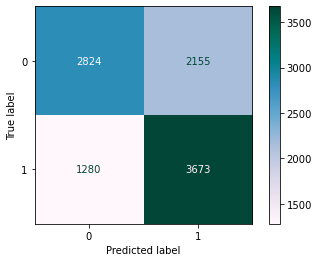

In [210]:
ConfusionMatrixDisplay.from_estimator(lr, X_test_cvc_df, y_test, cmap='PuBuGn');

## Fair amount of false positives, pretty good on false negatives.

In [211]:
preds = lr.predict(X_test_cvc_df)

In [212]:
recall_score(y_test, preds)

0.7415707651928124

In [213]:
precision_score(y_test, preds)

0.6302333562113933

In [214]:
f1_score(y_test, preds)

0.6813839161487801

## At an accuracy score of 65% this does beat the baseline score of 50%, but let's see if we can do better:

In [28]:
# start with a grid search over LogisticRegression-

pipe_params = {
    'cvec__max_features': [1_000, 2_000],
    'cvec__ngram_range' : [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    'cvec__stop_words'  : [None, 'english']
}

In [216]:
lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter = 4_000))
])

In [217]:
gs_1 = GridSearchCV(lr_pipe,
                    param_grid=pipe_params)

In [218]:
gs_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=4000))]),
             param_grid={'cvec__max_features': [1000, 2000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                               (2, 3), (3, 3)],
                         'cvec__stop_words': [None, 'english']})

In [219]:
gs_1.best_score_

0.649883924845964

In [220]:
gs_1.best_params_

{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [221]:
gs_1.score(X_test, y_test)

0.6650221506242449

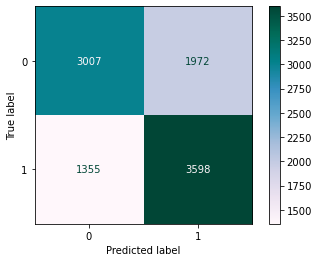

In [222]:
ConfusionMatrixDisplay.from_estimator(gs_1, X_test, y_test, cmap='PuBuGn');

In [223]:
preds = gs_1.predict(X_test)

In [224]:
recall_score(y_test, preds)

0.7264284272158288

In [225]:
precision_score(y_test, preds)

0.6459605026929982

In [226]:
f1_score(y_test, preds)

0.6838354081535684

## So the best parameters from the gridsearch are max_features set to 2_000, english stop words included, and unigrams only (for LogisticRegression, at least).

## The accuracy score for the test set has gone up slightly with this, from 65% to 67%...

## Let's try another gridsearch with an NB model:

In [26]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [29]:
gs_2 = GridSearchCV(nb_pipe,
                    param_grid=pipe_params)

In [229]:
gs_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [1000, 2000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                               (2, 3), (3, 3)],
                         'cvec__stop_words': [None, 'english']})

In [230]:
gs_2.best_score_

0.6449165752255496

In [231]:
gs_2.best_params_

{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [232]:
gs_2.score(X_test, y_test)

0.6559605316149819

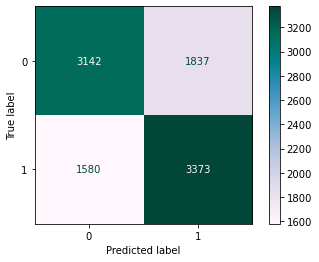

In [233]:
ConfusionMatrixDisplay.from_estimator(gs_2, X_test, y_test, cmap='PuBuGn');

## Slightly lower score from the most recent model at 66%. Fewest false positives of all the models so far, but the most false negatives.

In [234]:
preds = gs_2.predict(X_test)

In [235]:
recall_score(y_test, preds)

0.6810014132848778

In [236]:
precision_score(y_test, preds)

0.6474088291746641

In [237]:
f1_score(y_test, preds)

0.6637803798091114

## Let's try an SVM model:

In [30]:
pipe_params2 = {
    'cvec__stop_words'  : [None, 'english']
}

In [31]:
svm_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('sv', SVC())
])

In [32]:
gs_3 = GridSearchCV(svm_pipe,
                    param_grid=pipe_params2)

In [33]:
gs_3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('sv', SVC())]),
             param_grid={'cvec__stop_words': [None, 'english']})

In [34]:
gs_3.best_score_

0.6615981783543708

In [35]:
gs_3.best_params_

{'cvec__stop_words': 'english'}

In [36]:
gs_3.score(X_test, y_test)

0.6664317358034636

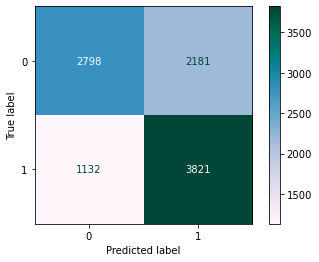

In [37]:
ConfusionMatrixDisplay.from_estimator(gs_3, X_test, y_test, cmap='PuBuGn');

## Slightly higher accuracy at 67%, tied with the gs1 model.

## Highest number of false postitives so far, fewest false negatives of all the models so far.

In [38]:
preds = gs_3.predict(X_test)

In [39]:
recall_score(y_test, preds)

0.7714516454673935

In [40]:
precision_score(y_test, preds)

0.6366211262912362

In [41]:
f1_score(y_test, preds)

0.6975810132359654

## Try another X, with the tokenized but unstemmed text:

In [42]:
data.head()

,body,subreddit,word_count,tokenized,clean_content,extreme
0,- Official slogan of Pepsi,politics,5,official slogan pepsi,offici slogan pepsi,0
1,"""took"" should be ""freed""",ChapoTrapHouse,4,took freed,took freed,1
2,Will tribes be completely free speech?,TheRedPill,6,tribes completely free speech,tribe complet free speech,1
3,Not an accident. They have crowned their queen...,The_Donald,25,accident crowned queen already warren others g...,accid crown queen alreadi warren other get pla...,1
4,Fucking love this man,The_Donald,4,fucking love man,fuck love man,1


In [18]:
X = data['tokenized']

In [19]:
# TTS-

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Initialize another cvec transformer, this time with no params:

In [20]:
cvec = CountVectorizer()

## Try this new cvec and X with LogisticRegression:

In [21]:
X_train_cvc = cvec.fit_transform(X_train)

In [22]:
X_test_cvc = cvec.transform(X_test)

In [23]:
X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec.get_feature_names_out())
X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec.get_feature_names_out())

In [24]:
lr2 = LogisticRegression(max_iter = 4_000) 

In [25]:
lr2.fit(X_train_cvc_df, y_train)

LogisticRegression(max_iter=4000)

In [26]:
lr2.score(X_test_cvc_df, y_test)

0.6704591220298026

## The slighlty higher accuracy score than the previous models.. best balance between the false positives and false negatives as well.

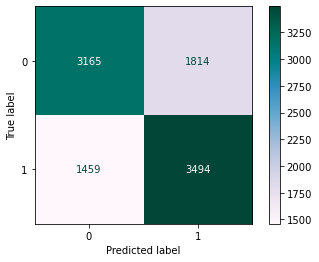

In [27]:
ConfusionMatrixDisplay.from_estimator(lr2, X_test_cvc_df, y_test, cmap='PuBuGn');

In [28]:
preds = lr2.predict(X_test_cvc_df)

In [29]:
recall_score(y_test, preds)

0.7054310518877448

In [30]:
precision_score(y_test, preds)

0.658251695553881

In [31]:
f1_score(y_test, preds)

0.681025241204561

## Try another X, with the completely unprocessed text:

In [21]:
X = data['body']

In [22]:
# TTS-

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Try this new X with the no-param cvec and LogisticRegression:

In [34]:
X_train_cvc = cvec.fit_transform(X_train)

In [35]:
X_test_cvc = cvec.transform(X_test)

In [36]:
X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec.get_feature_names_out())
X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec.get_feature_names_out())

In [37]:
lr3 = LogisticRegression(max_iter = 4_000) 

In [38]:
lr3.fit(X_train_cvc_df, y_train)

LogisticRegression(max_iter=4000)

In [39]:
lr3.score(X_test_cvc_df, y_test)

0.6731776077325815

## Tied with the tokenized text, above, for the highest accuracy score. Arguably an even better balance between false positives and false negatives.

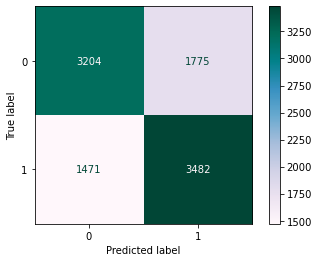

In [40]:
ConfusionMatrixDisplay.from_estimator(lr3, X_test_cvc_df, y_test, cmap='PuBuGn');

In [41]:
preds = lr3.predict(X_test_cvc_df)

In [42]:
recall_score(y_test, preds)

0.7030082778114274

In [43]:
precision_score(y_test, preds)

0.6623549552976983

In [44]:
f1_score(y_test, preds)

0.6820763956904995

## The models with no max features set for the cvec, run across the less-processed text (either just tokenized or raw text) seem to get slightly better scores.

## Try scaling the raw text X, with LogisticRegression, to see if that improves the score:

In [20]:
ss = StandardScaler()

## Initialize another cvec transformer, with max_features set to 3_000:

In [23]:
cvec2 = CountVectorizer(max_features=3_000)

In [24]:
X_train_cvc = cvec2.fit_transform(X_train)

In [25]:
X_test_cvc = cvec2.transform(X_test)

In [26]:
X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec2.get_feature_names_out())
X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec2.get_feature_names_out())

In [27]:
X_train_cvc_df_sc = ss.fit_transform(X_train_cvc_df)
X_test_cvc_df_sc = ss.transform(X_test_cvc_df)

In [45]:
lr4 = LogisticRegression(max_iter = 4_000) 

In [29]:
lr4.fit(X_train_cvc_df_sc, y_train)

LogisticRegression(max_iter=4000)

In [30]:
lr4.score(X_test_cvc_df_sc, y_test)

0.6575714861055175

## No improvement in accuracy with scaling-- the lowest score since the baseline.

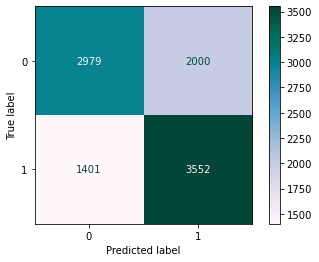

In [31]:
ConfusionMatrixDisplay.from_estimator(lr4, X_test_cvc_df_sc, y_test, cmap='PuBuGn');

## Worse performance than more recent models-- substantially more false positives.

In [32]:
preds = lr4.predict(X_test_cvc_df_sc)

In [33]:
recall_score(y_test, preds)

0.7171411265899454

In [34]:
precision_score(y_test, preds)

0.6397694524495677

In [35]:
f1_score(y_test, preds)

0.6762494050452166

## A comparison of the models so far:

| Model ID | Model | Scaled | Text | CVEC max_features | CVEC ngram range | CVEC stopwords | Accuracy | False Positives | False Negatives | Recall | Precision | F1 |
|:--------:|-------|:------:|:----:|:-----------------:|:----------------:|:--------------:|:--------:|:---------------:|:---------------:|:------:|:---------:|:--:|
| 1 | Logistic Regression      | no  | cleaned   | 1_000 | 1,1 | no  | .654 | 2155 | 1280 | .74 | .63 | .68 |
| 2 | Logistic Regression (GS) | no  | cleaned   | 2_000 | 1,1 | yes | .665 | 1972 | 1355 | .73 | .65 | .68 |
| 3 | Naive Bayes (GS)         | no  | cleaned   | 2_000 | 1,1 | yes | .656 | 1837 | 1580 | .68 | .65 | .66 |
| 4 | SVM (GS)                 | no  | cleaned   | none  | 1,1 | yes | .666 | 2181 | 1132 | .77 | .64 | .70 |
| 5 | Logistic Regression      | no  | tokenized | none  | 1,1 | no  | .670 | 1814 | 1459 | .71 | .66 | .68 |
| 6 | Logistic Regression      | no  | raw       | none  | 1,1 | no  | .673 | 1775 | 1471 | .70 | .66 | .68 |
| 7 | Logistic Regression      | yes | raw       | 3_000 | 1,1 | no  | .658 | 2000 | 1401 | .72 | .64 | .68 |

## So the hyperparameters that seem to give the highest scores are unigrams, English stopwords removed, and max features set to None (or at least the higher the better). Running the model across the tokenized text OR the raw text seems to improve the score, more so than using the processed (stemmed) text. Scaling seems to worsen the score. So far the best-performing models are both Logistic Regression (model 6 and model 5).

## I attempted to use the above information to run the top three best-performing models, LogisticRegression and SVM, across the best-performing hyperparameters, listed in the cell below, however I was unable to run the models without shutting down the kernel. 

In [ ]:
# run across a SVM, raw text, unscaled, no max features, stop words removed
# run across a logreg, raw text, unscaled, no max features, stop words removed

## I ran into the same problem when attempting to run Decision Tree, Random Forest, and Extra Trees classifiers.

## I need more computing power to successfully run these models across the large numbers of features created by max-featured count vectorization, so that will be the next phase of the project.

## With max features set to None the count vectorizer returns 33,272 columns of word tokens.

## I tried various proportions of max features in an attempt to get the given model to run successfully (half the total max features, 2/3s of the total max features, etc)-- either the kernel would shut down or occasionally the model would run for a long time, successfully finish, but have no real improvement on the accuracy score.

## The higher the max features on the count vectorizer the better the scores, but the more likely the kernel will be shut down due to too much computational effort...

In [ ]:
# Initialize another cvec transformer, with no max_features, English stopwords removed:

In [13]:
# cvec3 = CountVectorizer(stop_words='english')

In [14]:
# X = data['body']

In [15]:
# TTS-

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [16]:
# X_train_cvc = cvec3.fit_transform(X_train)

In [17]:
# X_test_cvc = cvec3.transform(X_test)

In [18]:
# X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec3.get_feature_names_out())
# X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec3.get_feature_names_out())

In [19]:
# X_train_cvc_df.shape

# more features than observations, use a linear kernel for the SVC

(29793, 33272)

In [16]:
# cvec4 = CountVectorizer(stop_words='english', max_features=16500)

# this is half of the maximum features for the dataset (33_272) (based on running max_features=None, above)-- 

In [17]:
# X_train_cvc = cvec4.fit_transform(X_train)

In [18]:
# X_test_cvc = cvec4.transform(X_test)

In [19]:
# X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec4.get_feature_names_out())
# X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec4.get_feature_names_out())

In [20]:
# since there are more features than observations in this dataset after the count vectorization, set the SVC to use a linear kernel-

# sv = SVC(kernel='linear')

In [ ]:
# sv.fit(X_train_cvc_df, y_train)

In [21]:
# lr5 = LogisticRegression(max_iter = 4_000)  

In [22]:
# lr5.fit(X_train_cvc_df, y_train)

LogisticRegression(max_iter=4000)

In [23]:
# lr5.score(X_test_cvc_df, y_test)

0.668445428916633

In [24]:
# cvec5 = CountVectorizer(stop_words='english', max_features=24800)

In [28]:
# X_train_cvc = cvec5.fit_transform(X_train)

In [29]:
# X_test_cvc = cvec5.transform(X_test)

In [30]:
# X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec5.get_feature_names_out())
# X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec5.get_feature_names_out())

In [31]:
# lr6 = LogisticRegression(max_iter = 4_000)  

In [32]:
# lr6.fit(X_train_cvc_df, y_train)

LogisticRegression(max_iter=4000)

In [33]:
# lr6.score(X_test_cvc_df, y_test)

0.6685461135722915

In [34]:
# cvec6 = CountVectorizer(stop_words='english', max_features=29300)

In [35]:
# X_train_cvc = cvec6.fit_transform(X_train)

In [36]:
# X_test_cvc = cvec6.transform(X_test)

In [37]:
# X_train_cvc_df = pd.DataFrame(X_train_cvc.toarray(), columns = cvec6.get_feature_names_out())
# X_test_cvc_df = pd.DataFrame(X_test_cvc.toarray(), columns = cvec6.get_feature_names_out())

In [38]:
# lr7 = LogisticRegression(max_iter = 4_000)  

In [39]:
# lr7.fit(X_train_cvc_df, y_train)

LogisticRegression(max_iter=4000)

## Above you can see my various attempts to get these models to run (assuming the fewer max features the better).

## For now I will try two final model structures, one comprised of the reddit post content and the word count for each post, and another comprised of the column listing each adjective in the post and the word count. These Xs will be run across the Logistic Regression model, comparing both count vectorization vs a TFIDF transformation to see which has the best performance when it comes to accuracy.

## Create a pre-X of the post content to vectorize before adding to the word count column:

In [18]:
data.head()

,body,subreddit,word_count,tokenized,clean_content,extreme,adjectives,adj_string
0,- Official slogan of Pepsi,politics,5,official slogan pepsi,offici slogan pepsi,0,['official'],official
1,"""took"" should be ""freed""",ChapoTrapHouse,4,took freed,took freed,1,[],
2,Will tribes be completely free speech?,TheRedPill,6,tribes completely free speech,tribe complet free speech,1,['free'],free
3,Not an accident. They have crowned their queen...,The_Donald,25,accident crowned queen already warren others g...,accid crown queen alreadi warren other get pla...,1,[],
4,Fucking love this man,The_Donald,4,fucking love man,fuck love man,1,['fucking'],fucking


In [19]:
# Since the best-scoring model, with the best ratio between false positives and false negatives, 
# was run on the raw, unprocessed posts in the 'body' column, I'm going to use that as part of my X-

preX = data['body']

In [20]:
# initialize a cvec with max features set to 16,500, approximately half of the full max feature count for the dataset (33,272)

In [56]:
# a count vectorizer with English stopwords removed and an ngram range of 1,1 had the highest scores in the table above, so that's
# what I'll use-

cvec3 = CountVectorizer(stop_words='english', max_features=16_500)

In [57]:
# transform the preX with the cvec and reset back into a df-

preX_cvc = cvec3.fit_transform(preX)

In [58]:
preX_cvc_df = pd.DataFrame(preX_cvc.toarray(), columns = cvec3.get_feature_names_out())

In [59]:
preX_cvc_df.shape

(39725, 16500)

In [20]:
# set the post word count column as a variable-

wc = data['word_count']

In [21]:
wc.shape

(39725,)

In [60]:
# append the word count column to the vectorized preX, set as new X-

X = pd.concat([preX_cvc_df, wc], axis = 1)

In [61]:
X.shape

(39725, 16501)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [63]:
X_train.shape

(29793, 16501)

In [64]:
X_test.shape

(9932, 16501)

In [65]:
y_train.shape

(29793,)

In [66]:
y_test.shape

(9932,)

In [67]:
# While the SVM model performed equally as well as the Logistic Regression model in the table above, it has been giving me
# more kernel problems as compared to Logistic Regression, I'm going to concentrate with LogReg going forward-

lr4.fit(X_train, y_train)

LogisticRegression(max_iter=4000)

In [68]:
lr4.score(X_test, y_test)

0.6716673378977044

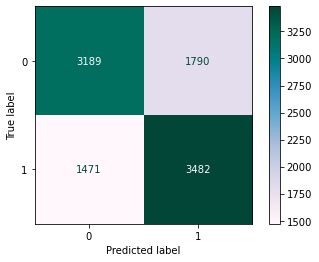

In [69]:
ConfusionMatrixDisplay.from_estimator(lr4, X_test, y_test, cmap='PuBuGn');

In [70]:
preds = lr4.predict(X_test)

In [71]:
recall_score(y_test, preds)

0.7030082778114274

In [72]:
precision_score(y_test, preds)

0.6604704097116844

In [73]:
f1_score(y_test, preds)

0.6810757946210269

In [43]:
# try again with the max features set slightly higher-

cvec4 = CountVectorizer(stop_words='english', max_features=20_500)

In [44]:
# transform the preX with the cvec and reset back into a df, same steps as last time-

preX_cvc = cvec4.fit_transform(preX)

In [45]:
preX_cvc_df = pd.DataFrame(preX_cvc.toarray(), columns = cvec4.get_feature_names_out())

In [46]:
# append the word count column to the vectorized preX, set as new X-

X = pd.concat([preX_cvc_df, wc], axis = 1)

In [47]:
X.shape

(39725, 20501)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [49]:
# use the same LogReg model as above-

lr4.fit(X_train, y_train)

LogisticRegression(max_iter=4000)

In [50]:
lr4.score(X_test, y_test)

0.6657269432138542

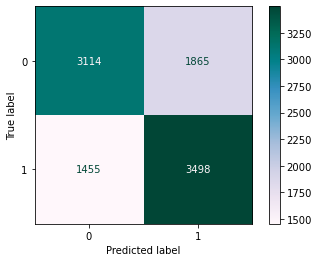

In [51]:
ConfusionMatrixDisplay.from_estimator(lr4, X_test, y_test, cmap='PuBuGn');

In [52]:
preds = lr4.predict(X_test)

In [53]:
recall_score(y_test, preds)

0.7062386432465173

In [54]:
precision_score(y_test, preds)

0.6522468767480888

In [55]:
f1_score(y_test, preds)

0.6781698332687088

## No real improvement from the last couple of models in the previous run.

## Try the same X (raw post text plus the title word counts) with the TFIDF transformer:

In [31]:
tiffydif = TfidfVectorizer()

In [32]:
# fit transform
preX_tfidf = tiffydif.fit_transform(preX)

In [33]:
# turn into a df-

preX_df = pd.DataFrame(preX_tfidf.toarray(), columns = tiffydif.get_feature_names_out())

In [34]:
# append the word count column to the aggregated title/domain, set as new X-

X = pd.concat([preX_df, wc], axis = 1)

In [35]:
X.shape

(39725, 38309)

In [80]:
X.head()

,00,000,00000,00000000,00001,0001,000164,000k,001,0014,...,ﾟヮﾟ,𝐀𝐆𝐀𝐈𝐍,𝐀𝐌𝐄𝐑𝐈𝐂𝐀,𝐃𝐈𝐃𝐍,𝐄𝐏𝐒𝐓𝐄𝐈𝐍,𝐆𝐑𝐄𝐀𝐓,𝐇𝐈𝐌𝐒𝐄𝐋𝐅,𝐊𝐈𝐋𝐋,𝐌𝐀𝐊𝐄,word_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
# use the same LogReg model as above-

lr4.fit(X_train, y_train)

# once again the kernel shut down, I need more computing power, moving on for now

## Try a model run across an X comprised of just the word count column and the column listing the adjectives occurring in each post:

In [36]:
preX = data['adj_string']

In [37]:
# initialize a cvec with no max features-

cvec5 = CountVectorizer()

In [38]:
# transform the preX with the cvec and reset back into a df-

preX_cvc = cvec5.fit_transform(preX)

In [39]:
preX_cvc_df = pd.DataFrame(preX_cvc.toarray(), columns = cvec5.get_feature_names_out())

In [41]:
preX_cvc_df.shape

(39725, 5450)

In [42]:
# append the word count column to the vectorized preX, set as new X-

X = pd.concat([preX_cvc_df, wc], axis = 1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [46]:
# use the same LogReg model as above-

lr4.fit(X_train, y_train)

LogisticRegression(max_iter=4000)

In [47]:
lr4.score(X_test, y_test)

0.5889045509464358

In [48]:
# much lower score; try the same X with tfidf-

preX_tfidf = tiffydif.fit_transform(preX)

In [49]:
# turn into a df-

preX_df = pd.DataFrame(preX_tfidf.toarray(), columns = tiffydif.get_feature_names_out())

In [50]:
# append the word count column to the vectorized preX, set as new X-

X = pd.concat([preX_cvc_df, wc], axis = 1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [52]:
# use the same LogReg model as above-

lr4.fit(X_train, y_train)

LogisticRegression(max_iter=4000)

In [53]:
lr4.score(X_test, y_test)

0.587696335078534

In [ ]:
# anothe lower score, moving on..

## Final results:

#### Previous models-

| Model ID | Model | Scaled | Text | CVEC max_features | CVEC ngram range | CVEC stopwords | Accuracy | False Positives | False Negatives | Recall | Precision | F1 |
|:--------:|-------|:------:|:----:|:-----------------:|:----------------:|:--------------:|:--------:|:---------------:|:---------------:|:------:|:---------:|:--:|
| 1 | Logistic Regression      | no  | cleaned   | 1_000 | 1,1 | no  | .654 | 2155 | 1280 | .74 | .63 | .68 |
| 2 | Logistic Regression (GS) | no  | cleaned   | 2_000 | 1,1 | yes | .665 | 1972 | 1355 | .73 | .65 | .68 |
| 3 | Naive Bayes (GS)         | no  | cleaned   | 2_000 | 1,1 | yes | .656 | 1837 | 1580 | .68 | .65 | .66 |
| 4 | SVM (GS)                 | no  | cleaned   | none  | 1,1 | yes | .666 | 2181 | 1132 | .77 | .64 | .70 |
| 5 | Logistic Regression      | no  | tokenized | none  | 1,1 | no  | .670 | 1814 | 1459 | .71 | .66 | .68 |
| 6 | Logistic Regression      | no  | raw       | none  | 1,1 | no  | .673 | 1775 | 1471 | .70 | .66 | .68 |
| 7 | Logistic Regression      | yes | raw       | 3_000 | 1,1 | no  | .658 | 2000 | 1401 | .72 | .64 | .68 |

#### Recent models-

| Model ID | Model | Word Count | Text | CVEC max_features | CVEC ngram range | CVEC stopwords | Accuracy | False Positives | False Negatives | Recall | Precision | F1 |
|:--------:|:------|:----------:|:----:|:-----------------:|:----------------:|:--------------:|:--------:|:---------------:|:---------------:|:------:|:---------:|:--:|
| 8 | Logistic Regression      | yes  | raw   | 16_500 | 1,1 | yes | .672 | 1790 | 1471 | .70 | .66 | .68 |
| 9 | Logistic Regression      | yes  | raw   | 20_500 | 1,1 | yes | .666 | 1865 | 1455 | .71 | .65 | .68 |

## The best performing model remains model 6, a Logistic Regression model with no set max features, run across the raw text of the posts, with English stopwords not removed and an ngram range of 1,1. This model has the best tradeoff between false positives and false negative, at 1775 (the fewest false positives of all the models) to 1471.

## The second best model is model 8, a Logistic Regression run across the count vectorized raw post text (with  max features set to 16, 500, ngram range of 1,1, English stopwords removed) along with the post word count. This model had the second lowest count of false positives (after the best model, model 6).

## The adjective count column added as X was a disappointment-- I think some more cleaning needs to be done on it to ensure that it only contains each adjective for the post of each associated row.

## I was only able to run a model with the TFIDF transformation across the smaller, less-well-performing X of the post word count combined with the adjective list, so I do not yet know how it would do when run across a larger X of the post content itself-- that is an iteration that needs to be done outside of a Jupyter notebook, requiring more computing power. Other iterations awaiting that ability include running a model of the best-performing hyperparameters (no max features for the cvec, English stopwords removed, run across the raw post text) across Logistic Regression and SVM models.

## It is notable that the best-performing model in this notebook had all of those ideal hyperparameters set but 1-- the removal of English stopwords.

## Using Spacy in a scikit pipeline might be another next step, possibly successful even in the Jupyter Lab notebook. I could add its matching functionality to a classifier pipeline, limiting it to only the adjectives and, later, to other dimensions of the text, such as Named Entities and Subjects (using dependency models).

## I will leave the subsequent models described above to next steps for the project.

## Considering how similar the extremist posts are to the non-extremist posts in this dataset, I am well-satisfied with an accuracy score of 67%.

## And since 67% is more than 10 points over the baseline accuracy score of 50% for this evenly balanced dataset, I have more than succeeded my goals set for the Problem Statement.